### Abalone Case Study Project:

Problem Statement:

The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.



In [1]:
import warnings
warnings.simplefilter("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import scipy.stats as stats
from scipy.stats import zscore

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

###### Importing all the dependencies

In [2]:
data_df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/abalone.csv")

Instead of downloading the entire dataset on my local computer I am simply loading the file directly from the GitHub repository link using the raw option.

In [3]:
data_df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In the above dataset I see that there is only one object datatype column and rest are all numeric columns. Since we need to find or rather predict the number of rings it becomes our target label. Rest all other columns are then automatically our feature columns that we will be making use of in predicting the label values.

Looking at the ring column it looks like there are numbers which are repeating so it can be classified into those numbers staging as 1 category. However, I feel it to be better as viewing the rings column to be containing continous data making this a Regression problem!

##### Exploratory Data Analysis (EDA)


In [4]:

data_df.shape

(4177, 9)

The total number of rows present in our dataset is 4177 and there are 9 columns including the target label.

In [5]:
data_df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

After checking for missing values we see that in each and every column that are no null value and therefore we won't have to worry about handling missing data.



In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


With the help of info method we are able to see the column datatype bifurcation. There are 7 float datatype columns, 1 integer datatype column and 1 object datatype column.

Since the object datatype is going to be one of the feature we will need to convert it later to numeric format using encoding techniques.

In [8]:
data_df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


As object datatype cannot be viewed in the describe metod we see 'sex' column being omitted automatically. By looking at the other columns we can ignore the 'rings' column as that will be our label and does not need to be pre processed. The other columns show slight deviations between the quantile ranges and the min-max values. However I do not see any drastic gap except for the 'height' and 'shell weight' columns. We will check for skewness and outliers and treat them if required.

In [9]:
data_df.skew()

Length           -0.639873
Diameter         -0.609198
Height            3.128817
Whole weight      0.530959
Shucked weight    0.719098
Viscera weight    0.591852
Shell weight      0.620927
Rings             1.114102
dtype: float64

For skewness the acceptable range is of +/-0.5. And we see that none of the columns fall under that range indicating the presence of outliers. So we will treat the problems and clean the dataset before building our machine learning models.



Visualization


Count Plot

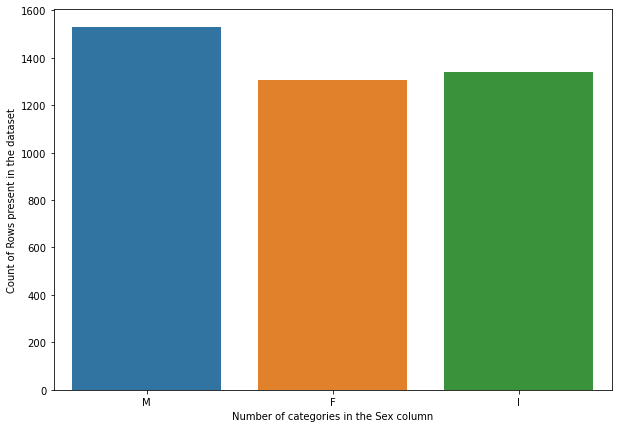

In [11]:
plt.figure(figsize=(10,7))
sns.countplot(x ='Sex', data = data_df)
plt.xlabel('Number of categories in the Sex column')
plt.ylabel('Count of Rows present in the dataset')
plt.show()

In the above countplot we can see that list of categories that are present in the 'Sex' column and they are divided into 3 class namely M - Male, F - Female and I - Infant types. Looking at the plot we can see there are is not much of a class imbalance here but we do see the Male options being higher than the other two. If we were going to treat this as a classification problem then we would have applied an oversampling technique to get rid of the slighest of the imbalance. But right now since we are opting for regression I am going to leave this data untouched and will simply encode it before feeding it into our models.



##### Bar Plot

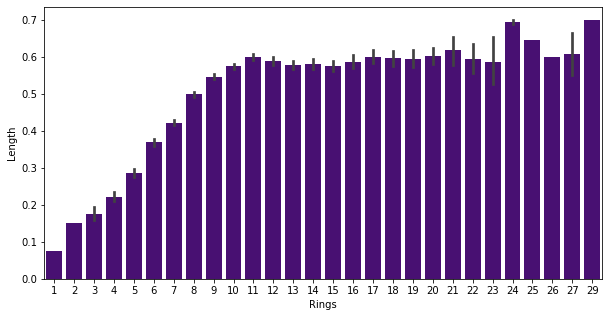

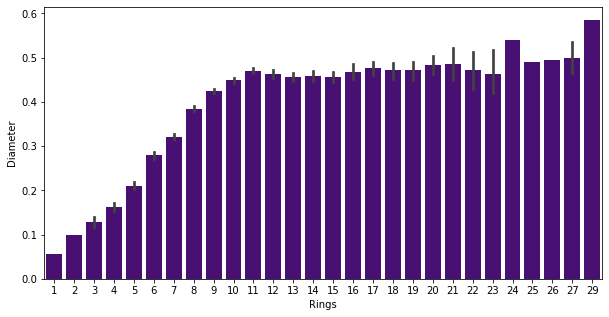

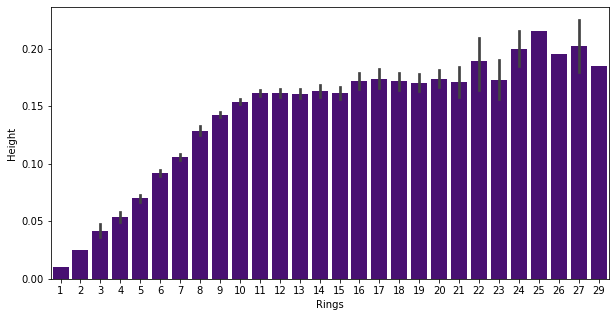

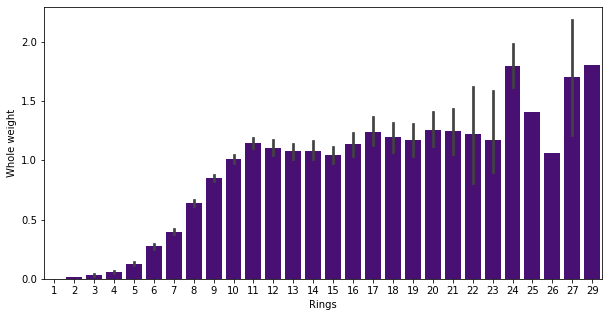

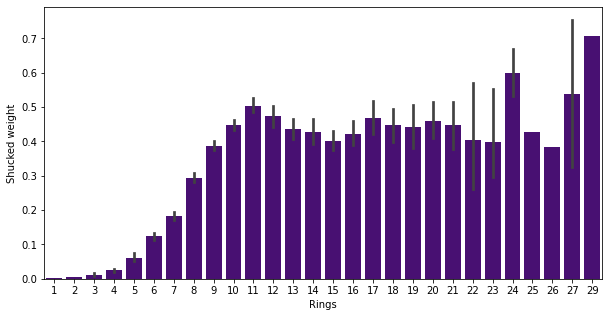

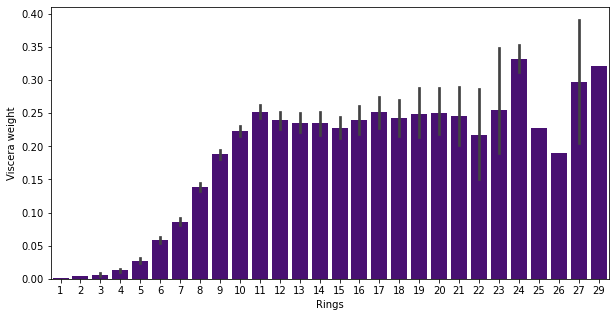

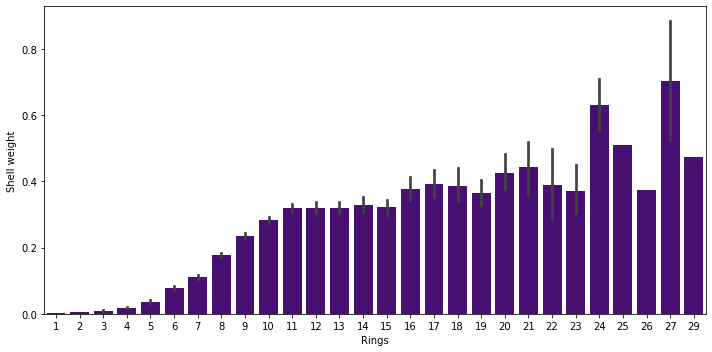

In [12]:
index=0
labels = data_df['Rings']
features = data_df.drop(['Rings', 'Sex'], axis=1)

for col in features.items():
    plt.figure(figsize=(10,5))
    sns.barplot(x=labels, y=col[index], data=data_df, color="indigo")
plt.tight_layout()
plt.show()

In the above bar plot when we look at the comparison between each feature column with the target label we see an upward trend in all of them at the beginning however that seems to have changed mid way and they it becomes an unever pattern. But it definitely indicates towards have a relationship amongst each feature vs label plot.



##### Box Plot


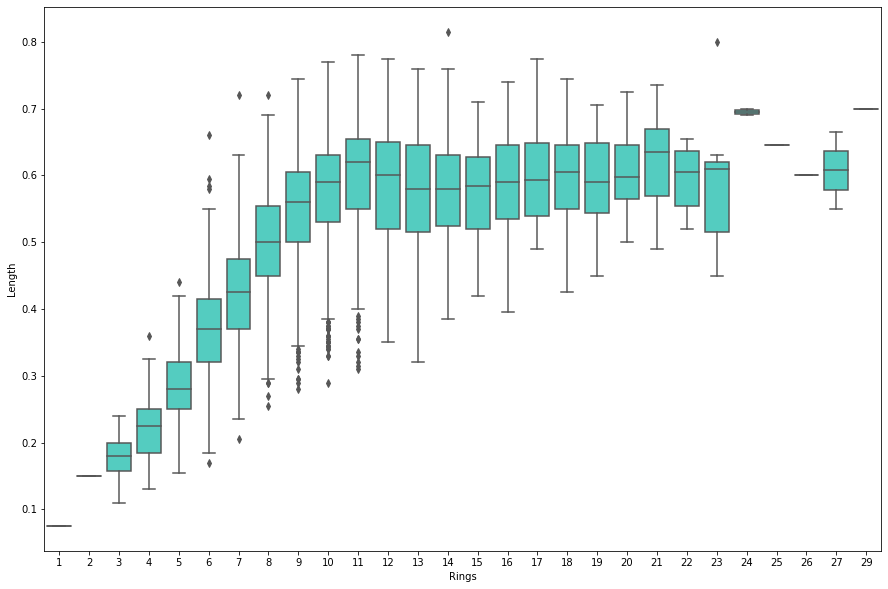

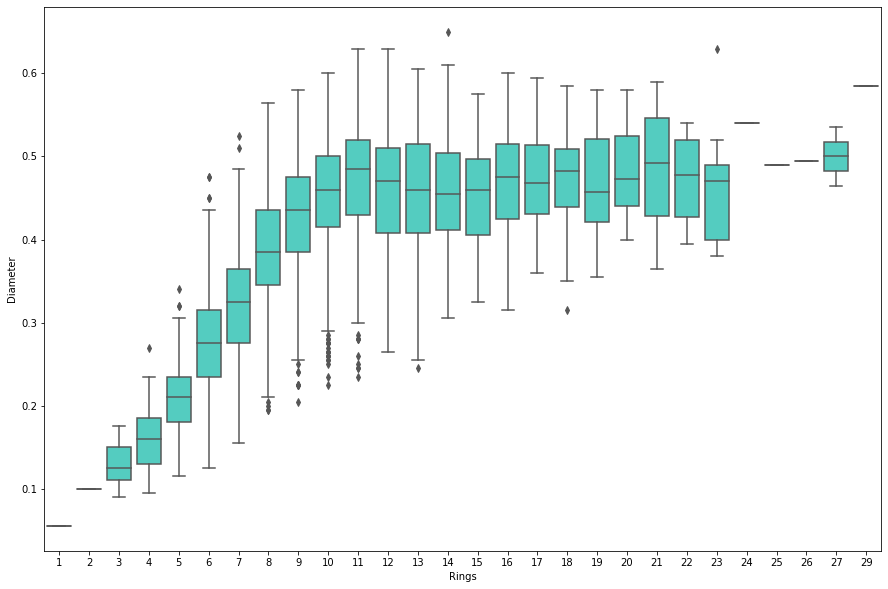

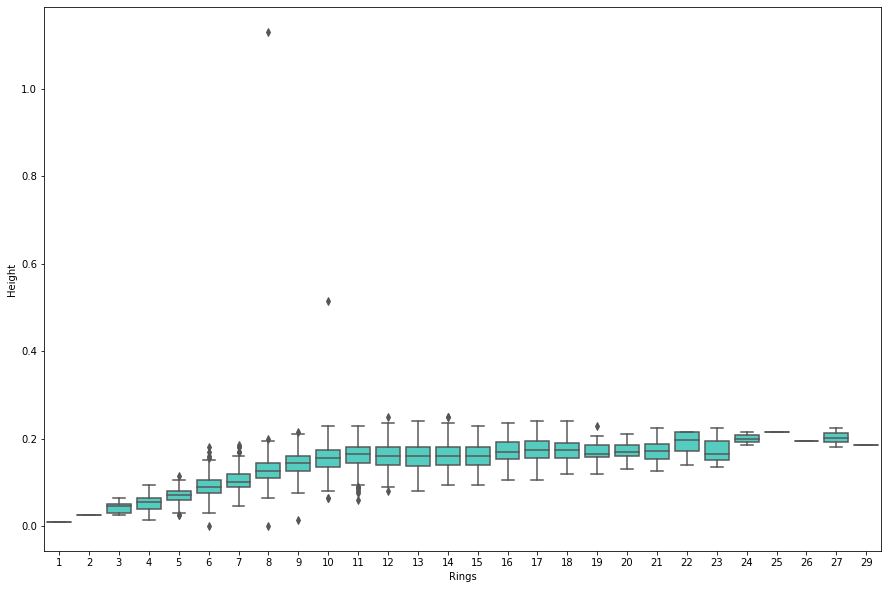

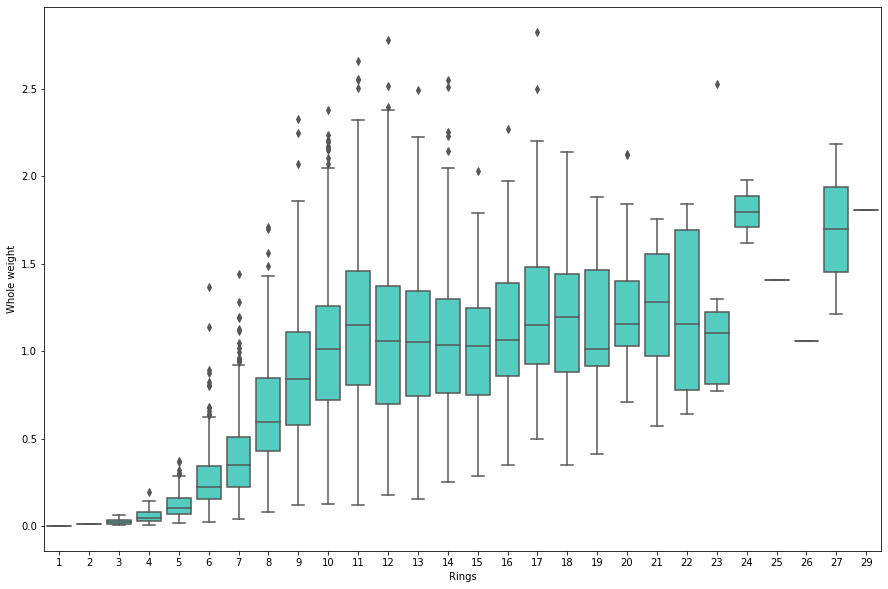

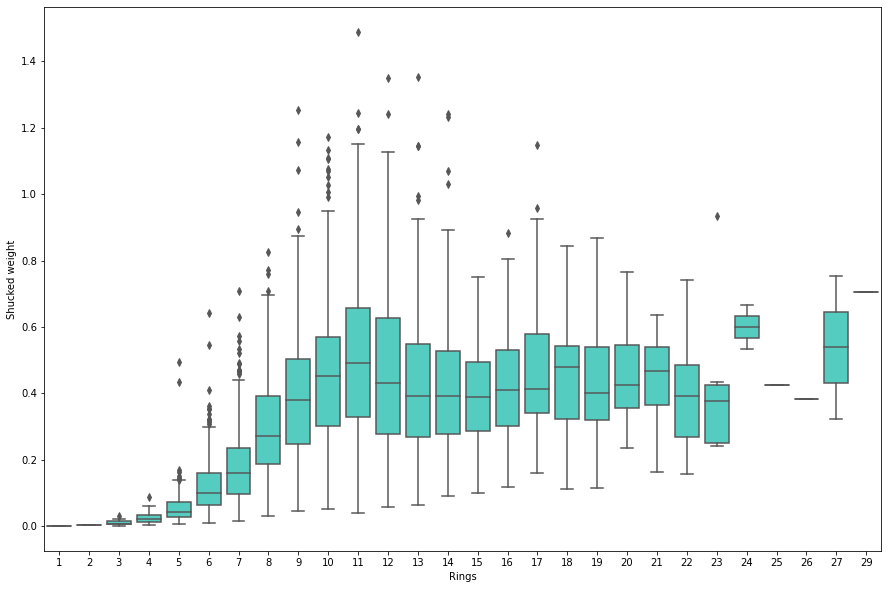

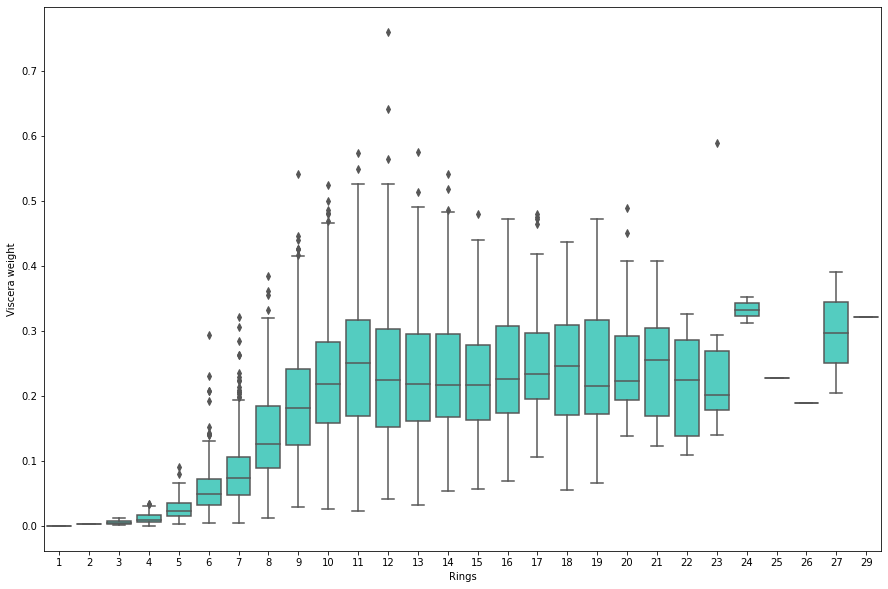

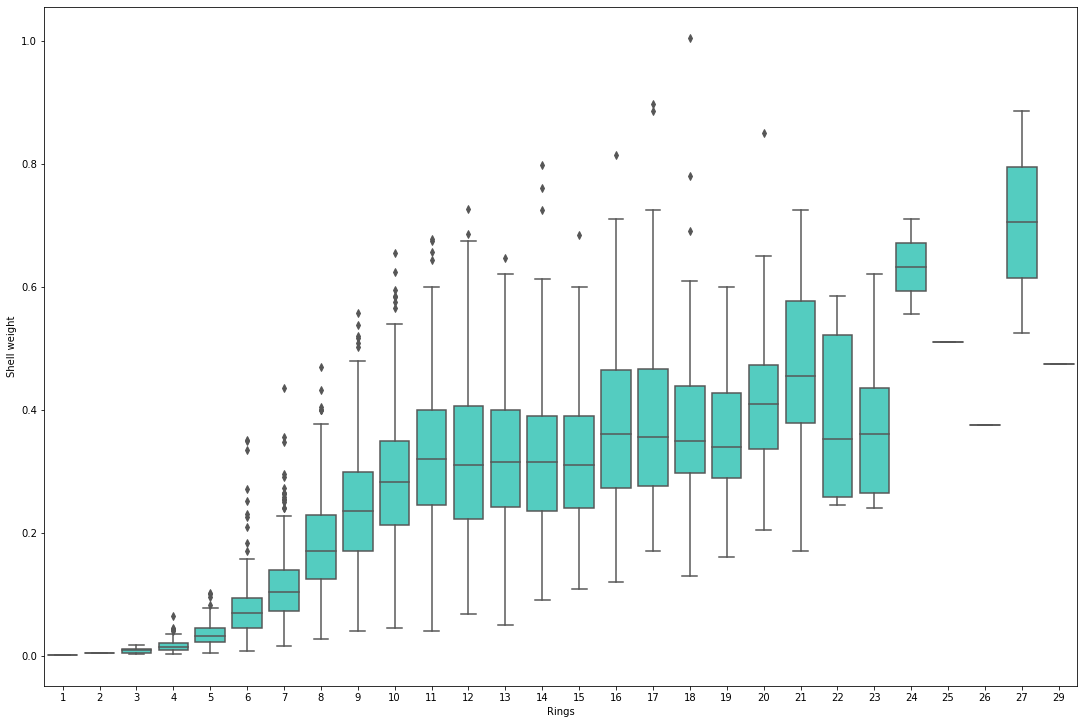

In [13]:
index = 0
for col in features.items():
    plt.figure(figsize=(15,10))
    sns.boxplot(x=labels, y=col[index], data=data_df, color="turquoise")
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

Using boxplot we are able to check through each and every value present in our label and how the outliers are positioned when located far off changes the range for those particular feature columns.



##### Distribution Plot


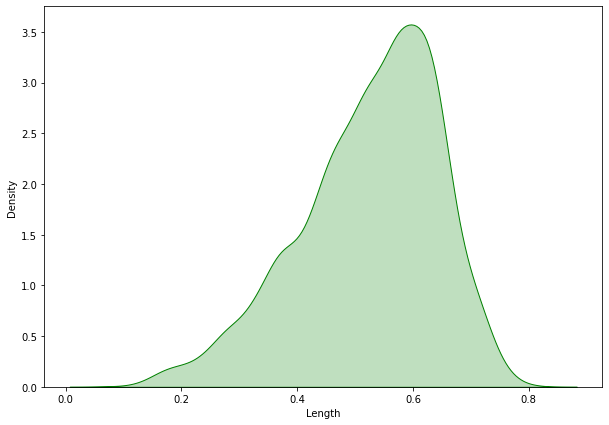

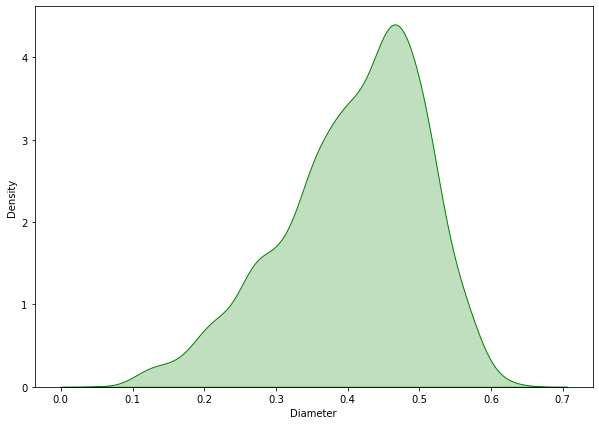

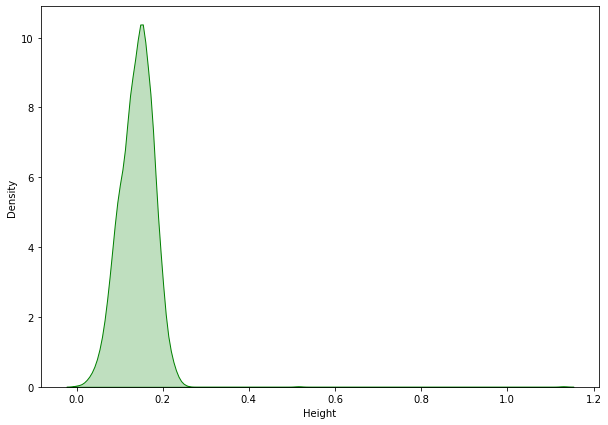

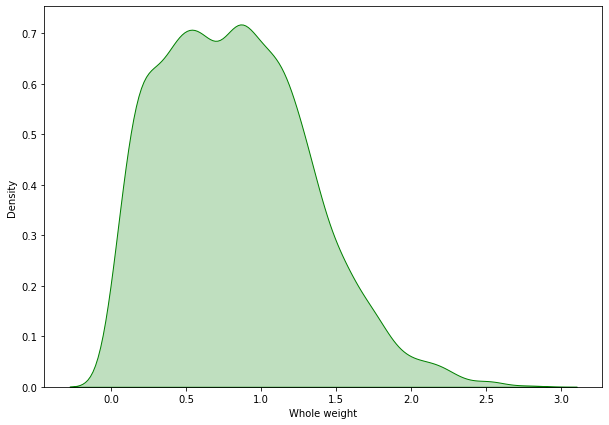

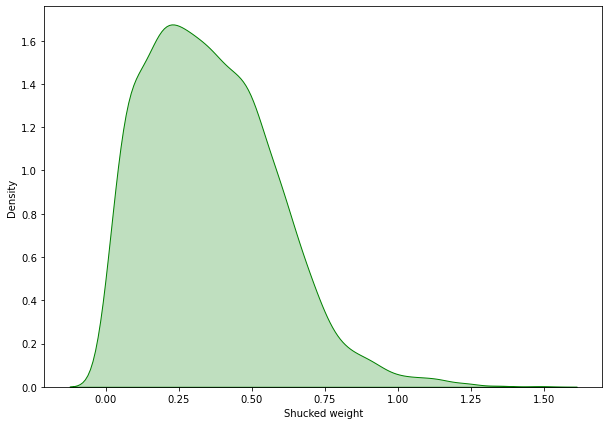

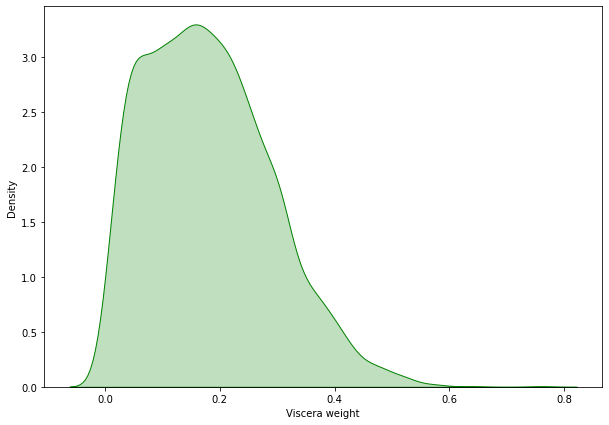

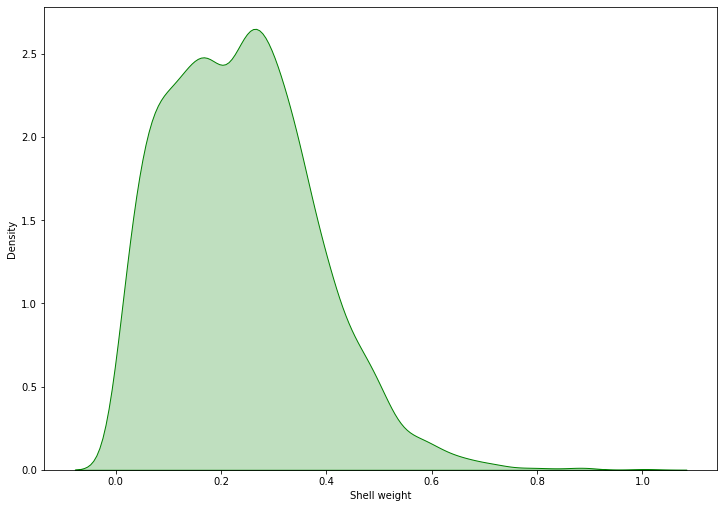

In [14]:
for col, value in features.items():
    plt.figure(figsize=(10,7))
    sns.distplot(value, hist=False, color="g", kde_kws={"shade": True})
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

In the above distribution plots we see that there are skewness due to the outliers which we saw in the boxplot but still many of they are able to retain or rather showcase a bell shape curve indicating a normal distribution. So we can assume that not all outliers are to be removed and some might actually we the genuine data therefore the outliers will need to be treated accordingly.



##### Pair Plot


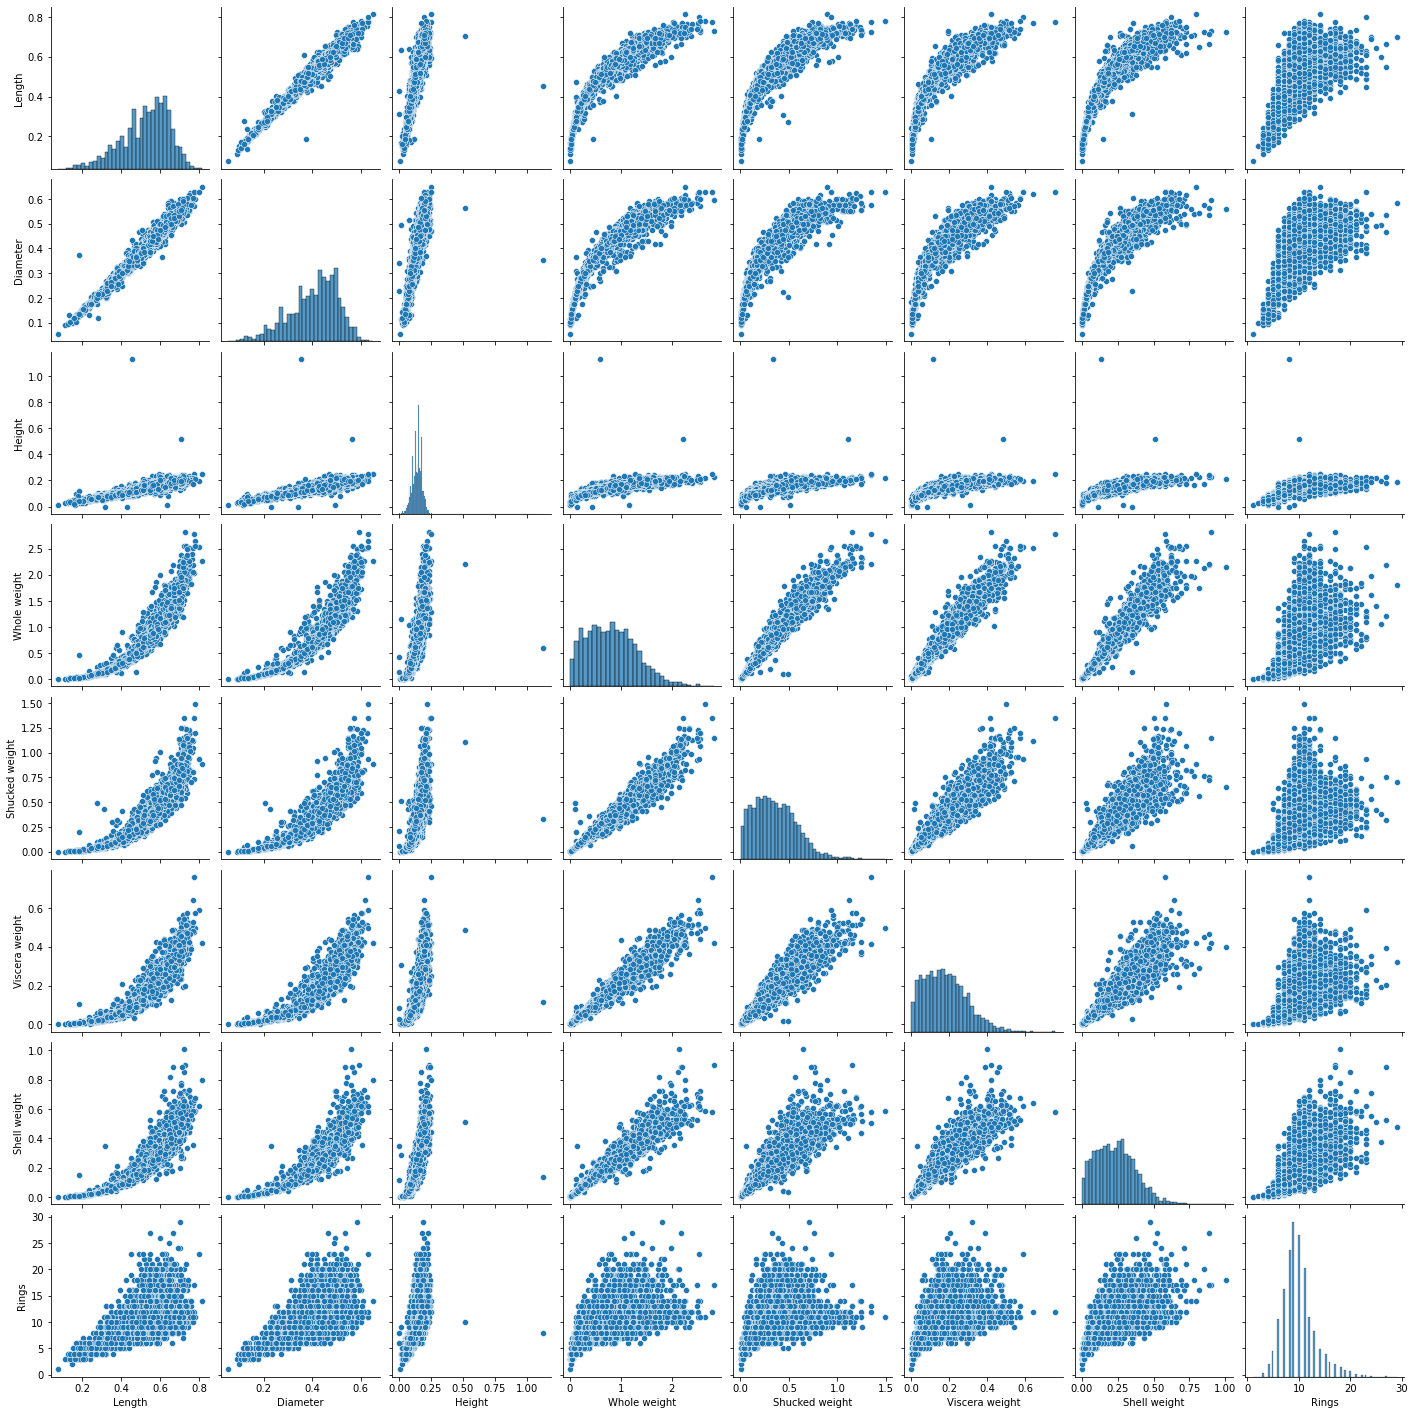

In [15]:
sns.pairplot(data_df)
plt.show()

The pairplot gives us a visualization on scatter plot + histogram showing us the outliers as well as the skewness data. As we are not able to see the histograms quite clearly I am going to map that separately as well.



##### Histogram


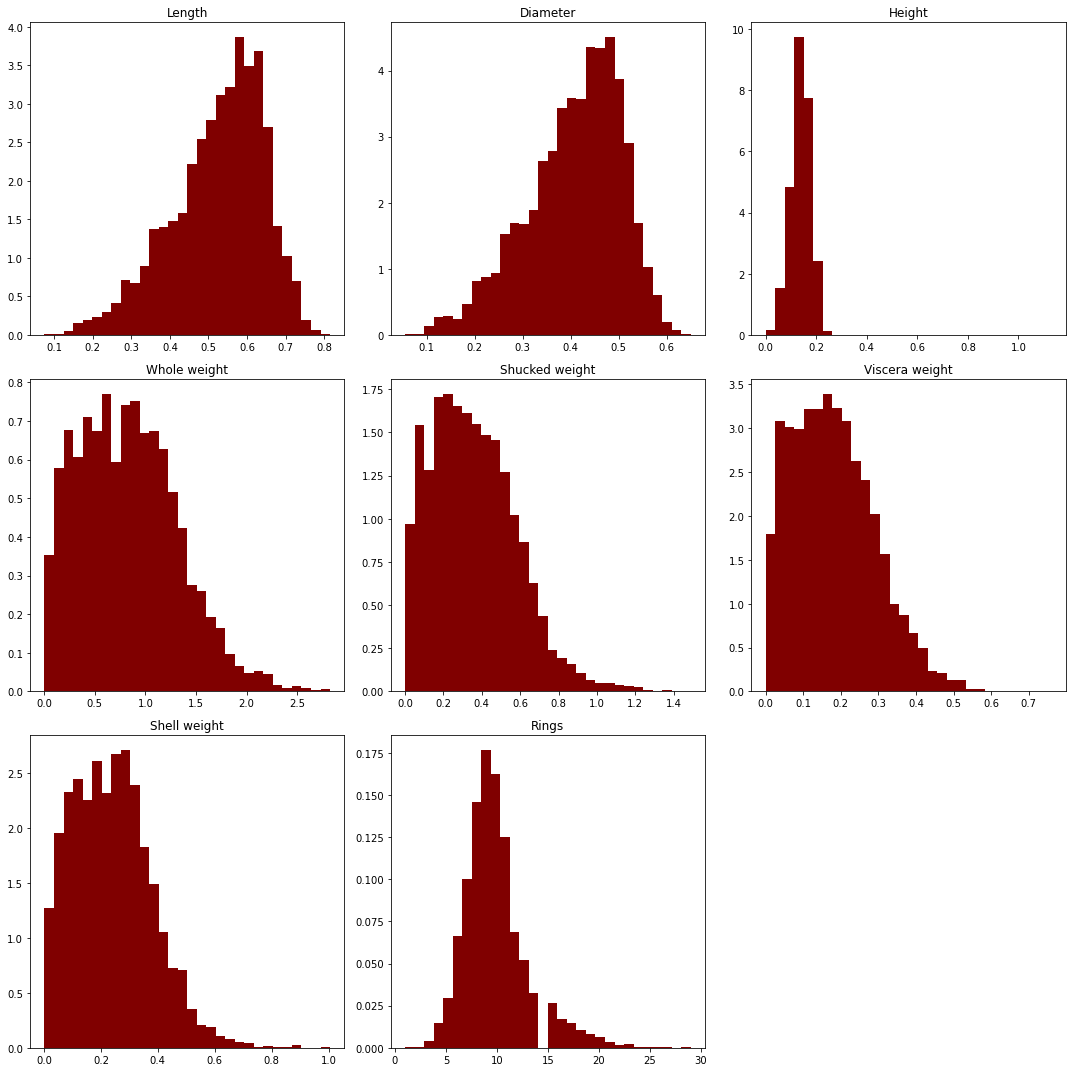

In [16]:
plt.rcParams['figure.figsize'] = (15,15)
data_df.hist(bins=30, color='maroon', density=True, label='Value', histtype='stepfilled', grid=False)
plt.tight_layout()
plt.show()

The above histogram shows us how the data is placed in our data set and if there are sections that have no entries for it. Like if I see in 'Rings' label the section near 15 is empty showing that possible there was not enough data collected that might fill in those number points too. Again in histogram we are confirming skewness that will need to be treated.



##### Correlation using a Heatmap
Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.

Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

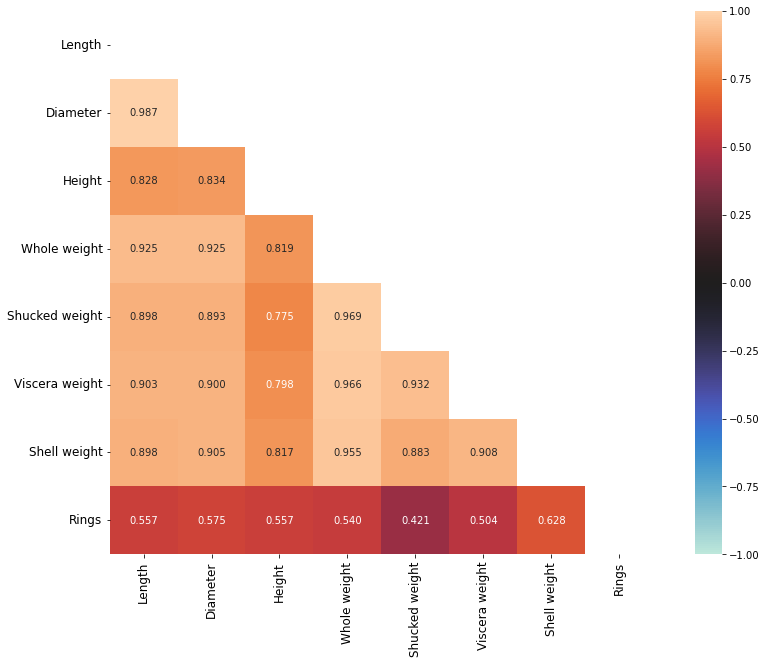

In [17]:
upper_triangle = np.triu(data_df.corr())
plt.figure(figsize=(15,10))
sns.heatmap(data_df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':10}, cmap="icefire", mask=upper_triangle)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In the above heatmap we do not see any negative correlation present amongst our dataset columns. Since 'Sex' is a categorical column it was not displaoyed in the heatmap. When we check the 'Rings' column comparing it with other feature columns we see positive correlation between them.

I see that the feature columns show multi collinearity towards each other but that is because they all have a role to play when we try predicting the 'Rings' columns which eventually provides the age of the abalone.



###### Encoding


In [19]:
data_df = pd.get_dummies(data_df)
data_df

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,1,0,0


I am using the pandas get_dummies method to encode the categorical object datatype 'Sex' column. Since get_dummies uses the One Hot Encoding mechanism we are able to get extra columns where the rows are converted to indicator variables.



##### Outlier removal

In [20]:
data_df.shape

(4177, 11)

Confirming the number of columns and rows before removing the outliers from the dataset.

In [22]:


# Z score method

z=np.abs(zscore(data_df))
threshold=3
np.where(z>3)

data_df=data_df[(z<3).all(axis=1)]
data_df

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,1,0,0


I have used the Z score method to get rid of outliers present in our dataset that are not in the acceptable range of +/-0.5 value of skewness.



In [24]:
data_df.shape

(4027, 11)

Checking the number of rows present in the dataset after applying the outlier removal technique.



In [25]:
# Percentage of Data Loss

data_loss=(4177-4027)/4177*100 
# 4177 (number of rows in the original dataframe) and 4027 (number of rows after outlier removal)
data_loss

3.5910940866650707

After removing the outliers we are checking the data loss percentage by comparing the rows in our original data set and the new data set post removal of the outliers.



#### Splitting the dataset into 2 variables namely 'X' and 'Y' for feature and label

In [26]:
X = data_df.drop('Rings', axis=1)
Y = data_df['Rings']

Variance Inflation Factor(VIF)


In [27]:
vif_data = pd.DataFrame()
vif_data["Features"]=X.columns
vif_data["VIF Value"]=[variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

         Features   VIF Value
0          Length   39.165074
1        Diameter   40.852649
2          Height    6.591310
3    Whole weight  108.277063
4  Shucked weight   28.666881
5  Viscera weight   17.151153
6    Shell weight   23.503036
7           Sex_F   27.011268
8           Sex_I   24.955912
9           Sex_M   30.318435


In theory if a VIF is above 10 it indicates high correlation and is cause for concern. Right now we have almost all the feature columns with a high number of VIF value. Feature selection process can be used to omit out the high VIF valued columns but in our dataset we already have very low number of feature columns so will need to try and retain them while making efforts to check if there are other ways to resolve the multi collinearity problem.

Note: In case I drop the high VIF valued columns like Length, Diameter, Whole weight, Shucked weight and Shell weight then I am able to get very high R2 and CV score (close to 100 percent). However it does not make any sense to me that I use only three features Sex, Height and Viscera weight to predict the label Rings (Age) in our dataset.



#### Feature Scaling

In [28]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X # Displaying all the features after applying scaling technique to avoid bias output

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
0,-0.569368,-0.420274,-1.166207,-0.633156,-0.603733,-0.723057,-0.630659,-0.670525,-0.699088,1.328833
1,-1.475358,-1.463127,-1.301806,-1.265644,-1.209410,-1.231104,-1.256033,-0.670525,-0.699088,1.328833
2,0.077768,0.153294,-0.081420,-0.275805,-0.448680,-0.331135,-0.161629,1.491368,-0.699088,-0.752540
3,-0.698795,-0.420274,-0.352617,-0.628771,-0.647342,-0.597255,-0.591574,-0.670525,-0.699088,1.328833
4,-1.647928,-1.567412,-1.573003,-1.310587,-1.257865,-1.318198,-1.373290,-0.670525,1.430434,-0.752540
...,...,...,...,...,...,...,...,...,...,...
4022,0.379764,0.466150,0.732171,0.184584,0.101275,0.612382,0.143240,1.491368,-0.699088,-0.752540
4023,0.595476,0.361865,-0.081420,0.357779,0.435609,0.375293,0.233138,-0.670525,-0.699088,1.328833
4024,0.681761,0.726863,1.816959,0.818169,0.854737,1.081721,0.604453,-0.670525,-0.699088,1.328833
4025,0.897473,0.831148,0.325376,0.639493,0.881387,0.825278,0.510647,1.491368,-0.699088,-0.752540


Even though all our feature columns were of numeric data type I was unhappy with the decimal place differences and was worried that it might make my model biased towards float and integers. Therefore I am using the Standard Scaler method to ensure all my feature columns have been standardized.



#### Creating the training and testing data sets

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

I am taking 20 percent of the complete dataset for training purpose and the remaing 80 percent with be used to train the machine learning models

### Machine Learning Model for Regression and Evaluation Metrics

In [30]:
# Regression Model Function

def reg(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # RMSE - a lower RMSE score is better than a higher one
    rmse = mean_squared_error(Y_test, pred, squared=False)
    print("RMSE Score is:", rmse)
    
    # R2 score
    r2 = r2_score(Y_test, pred, multioutput='variance_weighted')*100
    print("R2 Score is:", r2)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of r2 score minus cv score
    result = r2 - cv_score
    print("R2 Score - Cross Validation Score is", result)


I have built a function that splits the training and testing features and labels, then trains the model, predicts the label, calculates the RMSE score, generates the R2 score, calculates the Cross Validation score and finally finds the difference between the R2 score and Cross Validation score.



In [31]:
# Linear Regression Model

model=LinearRegression()
reg(model, X, Y)

RMSE Score is: 1.9427969153438613
R2 Score is: 52.424787948299134
Cross Validation Score: 43.69409878832823
R2 Score - Cross Validation Score is 8.7306891599709


Created the Linear Regression model and checked it's evaluation metrics.

In [32]:
# Support Vector Regression

model=SVR(C=1.0, epsilon=0.2, kernel='poly', gamma='auto')
reg(model, X, Y)

RMSE Score is: 2.0264575321905722
R2 Score is: 48.23920527341205
Cross Validation Score: 43.35139317049445
R2 Score - Cross Validation Score is 4.8878121029176


Created the Support Vector Regression model and checked it's evaluation metrics.

In [33]:
# Decision Tree Regressor

model=DecisionTreeRegressor(criterion="poisson", random_state=111)
reg(model, X, Y)

RMSE Score is: 2.7622948707286117
R2 Score is: 3.8241582212795167
Cross Validation Score: -17.45340976302325
R2 Score - Cross Validation Score is 21.277567984302767


Created the Decision Tree Regressor model and checked it's evaluation metrics.

In [34]:
# Random Forest Regressor

model=RandomForestRegressor(max_depth=2, max_features="sqrt")
reg(model, X, Y)

RMSE Score is: 2.217094160880256
R2 Score is: 38.04245535138196
Cross Validation Score: 24.888155333914995
R2 Score - Cross Validation Score is 13.154300017466966


Created the Random Forest Regressor model and checked it's evaluation metrics.



In [35]:
# K Neighbors Regressor

KNeighborsRegressor(n_neighbors=2, algorithm='kd_tree')
reg(model, X, Y)

RMSE Score is: 2.2189828878792315
R2 Score is: 37.93684799011493
Cross Validation Score: 24.604435881218123
R2 Score - Cross Validation Score is 13.332412108896804


Created the K Neighbors Regressor model and checked it's evaluation metrics.



In [36]:
# SGD Regressor

model=SGDRegressor(penalty='l1', max_iter=2000, learning_rate='optimal')
reg(model, X, Y)

RMSE Score is: 2.3833312448654143
R2 Score is: 28.403014838752526
Cross Validation Score: 18.255262677225815
R2 Score - Cross Validation Score is 10.14775216152671


Created the SGD Regressor model and checked it's evaluation metrics.



In [37]:
# Gradient Boosting Regressor

model=GradientBoostingRegressor(loss='quantile', n_estimators=200, max_depth=5)
reg(model, X, Y)

RMSE Score is: 3.033545012204305
R2 Score is: -15.991672090439746
Cross Validation Score: -44.75089182710158
R2 Score - Cross Validation Score is 28.759219736661837


Created the Gradient Boosting Regressor model and checked it's evaluation metrics.



In [38]:
# Ada Boost Regressor

model=AdaBoostRegressor(n_estimators=300, learning_rate=1.05, random_state=42)
reg(model, X, Y)

RMSE Score is: 2.246565116708978
R2 Score is: 36.384353592113854
Cross Validation Score: 14.54849164429008
R2 Score - Cross Validation Score is 21.835861947823773


Created the Ada Boost Regressor model and checked it's evaluation metrics.



In [39]:
# Extra Trees Regressor

model=ExtraTreesRegressor(n_estimators=200, max_features='sqrt', n_jobs=6)
reg(model, X, Y)

RMSE Score is: 1.8989912595823666
R2 Score is: 54.54602655958085
Cross Validation Score: 45.858783532374595
R2 Score - Cross Validation Score is 8.687243027206257


Created the Extra Trees Regressor model and checked it's evaluation metrics.



#### Hyper parameter tuning

In [40]:
# Choosing Support Vector Regression

fmod_param = {'kernel' : ['poly', 'sigmoid', 'rbf'], 
              'C' : [2.0, 3.0, 4.0], 
              'gamma' : ['scale', 'auto'], 
              'epsilon' : [0.2, 0.3, 0.4], 
              'shrinking' : [True, False]}


After comparing all the regression models I have selected Support Vector Regression as my best model and have listed down it's parameters above referring the sklearn webpage

In [41]:
GSCV = GridSearchCV(SVR(), fmod_param, cv=5)


I am using the Grid Search CV method for hyper parameter tuning my best model.



In [52]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [2.0, 3.0, 4.0], 'epsilon': [0.2, 0.3, 0.4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'sigmoid', 'rbf'],
                         'shrinking': [True, False]})

In [54]:
GSCV.best_params_

{'C': 4.0,
 'epsilon': 0.4,
 'gamma': 'scale',
 'kernel': 'rbf',
 'shrinking': True}

Here the Grid Search CV has provided me with the best parameters list out of all the combinations it used to train the model



In [55]:
Final_Model = SVR(C=4.0, epsilon=0.4, gamma='scale', kernel='rbf', shrinking=True)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_r2 = r2_score(Y_test, fmod_pred, multioutput='variance_weighted')*100
print("R2 score for the Best Model is:", fmod_r2)

R2 score for the Best Model is: 55.62575634005218


## I have successfully incorporated the Hyper Parameter Tuning on my Final Model and received the R2 score for it

#### Saving the best model


In [56]:
filename = "FinalModel_1.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_1.pkl']

### Finally I am saving my best regression model using the joblib library.